# Data Population
**Prerequisites**
- Access to a CDF Project.
- Know how to use a terminal, so you can run `pygen` from the command line to 
  generate the SDK.
- Knowledge of your the data and data model.

In [5]:
import warnings
warnings.filterwarnings('ignore')
# This is just to enable improting the generated SDK from the examples folder in the pygen repository
import sys
from tests.constants import REPO_ROOT
sys.path.append(str(REPO_ROOT / "examples" ))

## Introduction to Problem

`pygen` can be used to ingest data into an existing data model. It is well suited when the source data is nested and comes in a format such as `JSON`.

Before you can ingest data you need the following:

1. A Data Model Deployed to CDF.
2. Generated an SDK for it.

In this guide, we will use a drilling well as an example. First, we already have a deployed a model and generated an SDK for it.

The model was generated with the follwing config from the `pyproject.toml`

```toml
[tool.pygen]
data_models = [
    ["WellSpace", "OSDUWells", "1"],
]
top_level_package = "osdu_wells.client"
client_name = "OSDUClient"

```


This is a large model so we only show a small part of it in the picture below:

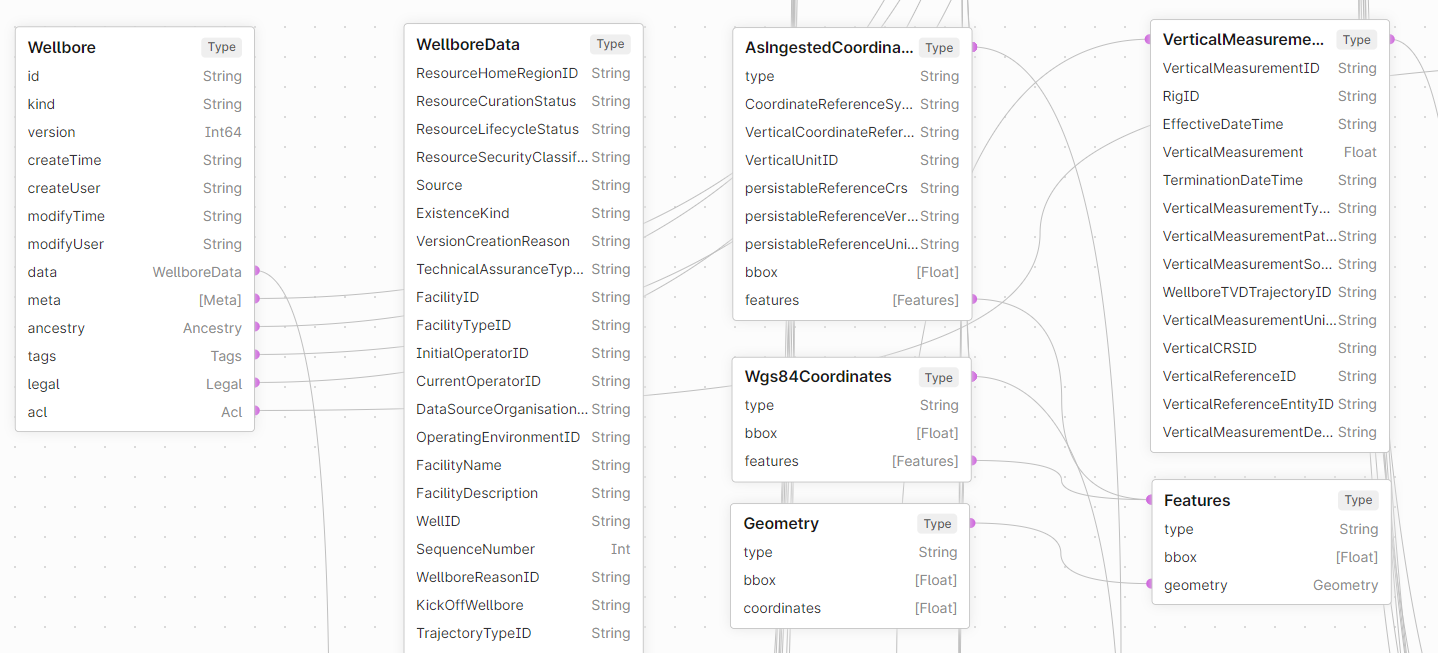

First, we will inspect some of the data we have available

In [11]:
from tests.constants import OSDUWellsFiles

In [12]:
print(OSDUWellsFiles.Data.well.read_text()[:500])

{
  "id": "namespace:master-data--Well:6c60ceb0-3521-57b7-9bd8-e1d7c9f66230",
  "kind": "osdu:wks:master-data--Well:1.3.0",
  "version": 1562066009929332,
  "acl": {
    "owners": [
      "someone@company.com"
    ],
    "viewers": [
      "someone@company.com"
    ]
  },
  "legal": {
    "legaltags": [
      "Example legaltags"
    ],
    "otherRelevantDataCountries": [
      "US"
    ],
    "status": "compliant"
  },
  "tags": {
    "NameOfKey": "String value"
  },
  "createTime": "2020-12-16T


As we see in the snippet above this is nested data, which is well suited for `pygen` supported ingestion

## External ID Hook

All data in CDF data models needs to have an `external_id` set. Often, source data does not come with an `external_id` set, and to help this `pygen` comes with a built in hook that enables you to set `external_id` when you are ingesting the data. The name of this hook is an `external_id_factory` and you can set it importing the `DomainModelApply` from your generated data classes. 

In [13]:
from cognite.pygen.utils.external_id_factories import uuid_factory
from osdu_wells.client.data_classes import DomainModelApply

In [14]:
DomainModelApply.external_id_factory = uuid_factory

The `external_id_factory` is a function that takes in two arguments, first a `type` which is the data class for the object and then a `dict` with the data for that partuclar object. `pygen` comes with a few generic external id factories you can use, see [External ID factory](../api/utils_external_id_factory.html) These can be good for testing an exploration, but we recommend that you write your own factory function for (at least) the most important classes.

In the example below, we write a factory method that sets the ID for all wells. Looking at the snippet below we note that the wells have an `id` from the source system, so we would like to use this as the `external_id`.

In [15]:
from osdu_wells.client.data_classes import WellApply

def well_factory(domain_cls: type, data: dict) -> str:
    if domain_cls is WellApply:
        return data["id"]
    else:
        # Fallback to uuid factory
        return uuid_factory(domain_cls, data)

# Finally, we set the new factory
DomainModelApply.external_id_factory = well_factory

## Ingesting the Data

After we have set the `external_id_factory` we are all good to go. `pygen` is generating `pydantic` data classes which means we can use the built in support for json validation in `pydantic`

In [29]:
%%time
well_data = WellApply.model_validate_json(OSDUWellsFiles.Data.well.read_text())

CPU times: total: 0 ns
Wall time: 1.01 ms


`pygen` also support `pydantic` v1. The same line above for v1 is

```python
well_data = WellApply.parse_raw(OSDUWellsFiles.Data.well.read_text())
```

In [30]:
well_data

,value
space,IntegrationTestsImmutable
external_id,namespace:master-data--Well:6c60ceb0-3521-57b7...
existing_version,None
acl,"{'space': 'IntegrationTestsImmutable', 'extern..."
ancestry,"{'space': 'IntegrationTestsImmutable', 'extern..."
create_time,2020-12-16T11:46:20.163Z
create_user,some-user@some-company-cloud.com
data,"{'space': 'IntegrationTestsImmutable', 'extern..."
id,namespace:master-data--Well:6c60ceb0-3521-57b7...
kind,osdu:wks:master-data--Well:1.3.0


We note that the `external_id` field is set to the `id` for the well. If we check the other objects we see these gets an `external_id` = `class_name.lower():uuid_string`

In [31]:
well_data.acl

,value
space,IntegrationTestsImmutable
external_id,aclapply:6bb1bd18-284a-40d7-b706-c6e4d8161eac
existing_version,None
owners,[someone@company.com]
viewers,[someone@company.com]


We can now upload this data by creating a domain client and call `apply` on the `well` methods. 

In [32]:
from osdu_wells.client import OSDUClient

In [33]:
well_client = OSDUClient.from_toml("config.toml")

In [75]:
result = well_client.well.apply(well_data);
print(f"{len(result.nodes)} nodes and {len(result.edges)} uploaded")

30 nodes and 19 uploaded


Note that `pygen` have the method `.to_instances_apply()` you can use to check which `nodes`and `edges` were created.

We note that `pygen` created in total 30 nodes and 19 edges between these nodes.

The edges were of 15 different types, and the data from the nodes was ingested into 24 different containers

In [67]:
instances = well_data.to_instances_apply()

In [68]:
len(instances.nodes), len(instances.edges)

(30, 19)

In [69]:
unique = set(edge.type.external_id for edge in instances.edges)
len(unique), unique

(15,
 {'AsIngestedCoordinates.features',
  'TechnicalAssurances.AcceptableUsage',
  'TechnicalAssurances.Reviewers',
  'TechnicalAssurances.UnacceptableUsage',
  'Well.meta',
  'WellData.FacilityEvents',
  'WellData.FacilityOperators',
  'WellData.FacilitySpecifications',
  'WellData.FacilityStates',
  'WellData.GeoContexts',
  'WellData.HistoricalInterests',
  'WellData.NameAliases',
  'WellData.TechnicalAssurances',
  'WellData.VerticalMeasurements',
  'Wgs84Coordinates.features'})

In [70]:
unique = set([source.source for node in instances.nodes for source in node.sources])
len(unique), unique

(24,
 {ContainerId(space='IntegrationTestsImmutable', external_id='AcceptableUsage'),
  ContainerId(space='IntegrationTestsImmutable', external_id='Acl'),
  ContainerId(space='IntegrationTestsImmutable', external_id='Ancestry'),
  ContainerId(space='IntegrationTestsImmutable', external_id='AsIngestedCoordinates'),
  ContainerId(space='IntegrationTestsImmutable', external_id='FacilityEvents'),
  ContainerId(space='IntegrationTestsImmutable', external_id='FacilityOperators'),
  ContainerId(space='IntegrationTestsImmutable', external_id='FacilitySpecifications'),
  ContainerId(space='IntegrationTestsImmutable', external_id='FacilityStates'),
  ContainerId(space='IntegrationTestsImmutable', external_id='Features'),
  ContainerId(space='IntegrationTestsImmutable', external_id='GeoContexts'),
  ContainerId(space='IntegrationTestsImmutable', external_id='Geometry'),
  ContainerId(space='IntegrationTestsImmutable', external_id='HistoricalInterests'),
  ContainerId(space='IntegrationTestsImmuta

In [71]:
instances.nodes

,instance_type,space,external_id,sources
0,node,IntegrationTestsImmutable,namespace:master-data--Well:6c60ceb0-3521-57b7...,[{'properties': {'acl': {'space': 'Integration...
1,node,IntegrationTestsImmutable,metaapply:5c7a1300-a73b-42b5-8bc7-2ae0fa634e4e,"[{'properties': {'kind': 'Unit', 'name': 'm', ..."
2,node,IntegrationTestsImmutable,aclapply:6bb1bd18-284a-40d7-b706-c6e4d8161eac,[{'properties': {'owners': ['someone@company.c...
3,node,IntegrationTestsImmutable,ancestryapply:6359de65-33cb-453a-9ff8-b8d616cb...,"[{'properties': {'parents': []}, 'source': {'s..."
4,node,IntegrationTestsImmutable,welldataapply:bbadbfac-e36c-4601-bd64-930ce0e2...,[{'properties': {'BusinessIntentionID': 'names...
5,node,IntegrationTestsImmutable,facilityeventsapply:51d92602-b300-405f-b28b-e1...,[{'properties': {'EffectiveDateTime': '2020-02...
6,node,IntegrationTestsImmutable,facilityoperatorsapply:b2ddddea-8805-43d3-89c1...,[{'properties': {'EffectiveDateTime': '2020-02...
7,node,IntegrationTestsImmutable,facilityspecificationsapply:2a0b199b-75e2-4da5...,[{'properties': {'EffectiveDateTime': '2020-02...
8,node,IntegrationTestsImmutable,facilitystatesapply:b720999c-5269-45da-9652-da...,[{'properties': {'EffectiveDateTime': '2020-02...
9,node,IntegrationTestsImmutable,geocontextsapply:715281cb-3e7b-4ce1-bb78-25db4...,[{'properties': {'GeoPoliticalEntityID': 'name...


In [38]:
instances.edges

,instance_type,space,external_id,type,start_node,end_node
0,edge,IntegrationTestsImmutable,namespace:master-data--Well:6c60ceb0-3521-57b7...,"{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern..."
1,edge,IntegrationTestsImmutable,welldataapply:bbadbfac-e36c-4601-bd64-930ce0e2...,"{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern..."
2,edge,IntegrationTestsImmutable,welldataapply:bbadbfac-e36c-4601-bd64-930ce0e2...,"{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern..."
3,edge,IntegrationTestsImmutable,welldataapply:bbadbfac-e36c-4601-bd64-930ce0e2...,"{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern..."
4,edge,IntegrationTestsImmutable,welldataapply:bbadbfac-e36c-4601-bd64-930ce0e2...,"{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern..."
5,edge,IntegrationTestsImmutable,welldataapply:bbadbfac-e36c-4601-bd64-930ce0e2...,"{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern..."
6,edge,IntegrationTestsImmutable,welldataapply:bbadbfac-e36c-4601-bd64-930ce0e2...,"{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern..."
7,edge,IntegrationTestsImmutable,welldataapply:bbadbfac-e36c-4601-bd64-930ce0e2...,"{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern..."
8,edge,IntegrationTestsImmutable,welldataapply:bbadbfac-e36c-4601-bd64-930ce0e2...,"{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern..."
9,edge,IntegrationTestsImmutable,welldataapply:bbadbfac-e36c-4601-bd64-930ce0e2...,"{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern...","{'space': 'IntegrationTestsImmutable', 'extern..."
